# Frequent Items Analysis:

## Apriori Alogrithm:

Apriori is a classic algorithm for mining frequent itemsets in transactional databases. It works by iteratively identifying frequent itemsets based on a minimum support threshold and exploiting the downward closure property. In the below code, Apriori is used to analyze transactional data per department, extracting frequent itemsets that meet a minimum support threshold, facilitating insights into product associations within each department.

Given the original dataset size of 32 million, we opted to analyze a 10% sample to reduce computational complexity while still capturing significant patterns for market basket analysis. This downscaled dataset enables efficient processing without compromising the extraction of valuable insights regarding item associations.

### Subsetting the full dataset for apiori mechanism
Since we are finding apriori rules, we will have to get all the products within an order. So we will randomly select 10% of all the orders. 

To facilitate the extraction of Apriori rules, it was imperative to obtain all products within an order. Accordingly, a stratified random sampling approach was employed, selecting 10% of all orders from the full dataset. Upon analysis, it was discovered that the sampled dataset exhibited comparability with the actual dataset. This observation is visually depicted in the plot below. For further insights into the random sampling process and visualization techniques utilized, please consult the code documented in the EDA.rmd file.

![Top 15 Products for Sample and Full Dataset](images/product_sample.jpeg)
![Top 15 Aisles for Sample and Full Dataset](images/aisle_sample.jpeg)

## Apriori Source Code:

### Imports

In [1]:
!pip3 install pyspark
from pyspark.sql import SparkSession, Row
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.sql.functions import expr
import zipfile
import os
from pyspark.sql.functions import expr, col, array, udf, explode, when
from pyspark.sql.types import IntegerType
from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd
from pyspark.sql.functions import collect_list, sum as spark_sum
from mlxtend.preprocessing import TransactionEncoder

Defaulting to user installation because normal site-packages is not writeable


### Initialize Spark Session

In [2]:
# Step 1: Initialize SparkSession
spark = SparkSession.builder \
    .appName("MarketBasketAnalysis") \
    .master("local[*]") \
    .config("spark.executor.memory", "100g") \
    .config("spark.memory.offHeap.enabled", True) \
    .config("spark.memory.offHeap.size", "200g") \
    .getOrCreate()

24/04/07 17:21:30 WARN Utils: Your hostname, personal resolves to a loopback address: 127.0.1.1; using 192.168.68.66 instead (on interface wlp3s0)
24/04/07 17:21:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/07 17:21:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Load Sampled Dataset

In [4]:
# Extract csv file for given sample dataset
filename = f"apriori_subset.csv"

order_products = spark.read.csv(filename, header=True, inferSchema=True)

### Group products into a list for common order_id

In [6]:
# Group products for common order_id
grouped_orders = order_products.groupBy("order_id") \
    .agg(collect_list("product_name").alias("products"))

# Convert DataFrame to Python list of lists
dataset = grouped_orders.select("order_id","products").rdd.map(lambda row: row.products).collect()

### Transaction Encoding

In [7]:
# Transaction Encoding list of lists
te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)

### Apply Apriori

In [14]:
# Apply Apriori with appropriate min_support value
frequent_itemsets = apriori(df, min_support=0.008, use_colnames=True)

print(frequent_itemsets.sort_values(by='support', ascending=False))

      support                  itemsets
7    0.147071                  (Banana)
6    0.118188  (Bag of Organic Bananas)
96   0.082568    (Organic Strawberries)
47   0.074689    (Organic Baby Spinach)
72   0.065982    (Organic Hass Avocado)
..        ...                       ...
29   0.008124    (Ground Turkey Breast)
125  0.008106   (Total 0% Greek Yogurt)
93   0.008094      (Organic Sour Cream)
110  0.008055         (Red Raspberries)
61   0.008028   (Organic Fat Free Milk)

[159 rows x 2 columns]


The analysis reveals that bananas, followed by bagged organic bananas and organic strawberries, are the most frequently purchased items, indicating their popularity among customers. Notably, the inclusion of organic produce items like bagged organic bananas, organic strawberries, organic baby spinach, and organic hass avocados in the frequent itemsets suggests a strong preference for organic options among shoppers. This insight underscores an opportunity for retailers to capitalize on this demand by expanding their organic product offerings and strategically placing these items to cater to customer preferences, potentially boosting sales and enhancing customer satisfaction.

### Save Frequent Items

In [15]:
# output frequent items of that department
frequent_csv_name = f"apriori_frequent.csv"
frequent_itemsets.to_csv(frequent_csv_name, index=False)

### Save Association Rules

In [34]:
association = association_rules(frequent_itemsets, metric="lift", min_threshold=0.001)
print(association)
asso_csv_name = f"apriori_association.csv"
association.to_csv(asso_csv_name, index=False)

                 antecedents               consequents  antecedent support  \
0     (Organic Baby Spinach)  (Bag of Organic Bananas)            0.074689   
1   (Bag of Organic Bananas)    (Organic Baby Spinach)            0.118188   
2     (Organic Hass Avocado)  (Bag of Organic Bananas)            0.065982   
3   (Bag of Organic Bananas)    (Organic Hass Avocado)            0.118188   
4      (Organic Raspberries)  (Bag of Organic Bananas)            0.042345   
5   (Bag of Organic Bananas)     (Organic Raspberries)            0.118188   
6   (Bag of Organic Bananas)    (Organic Strawberries)            0.118188   
7     (Organic Strawberries)  (Bag of Organic Bananas)            0.082568   
8       (Organic Whole Milk)  (Bag of Organic Bananas)            0.042964   
9   (Bag of Organic Bananas)      (Organic Whole Milk)            0.118188   
10          (Cucumber Kirby)                  (Banana)            0.029403   
11                  (Banana)          (Cucumber Kirby)          

#### Top Associations based on Support

Support is a measure of how frequently an item or itemset appears in the dataset.

In [35]:
print(association[["antecedents", "consequents", "support"]].sort_values(by='support', ascending=False).head(10))

                 antecedents               consequents   support
6   (Bag of Organic Bananas)    (Organic Strawberries)  0.019458
7     (Organic Strawberries)  (Bag of Organic Bananas)  0.019458
2     (Organic Hass Avocado)  (Bag of Organic Bananas)  0.019399
3   (Bag of Organic Bananas)    (Organic Hass Avocado)  0.019399
27    (Organic Strawberries)                  (Banana)  0.017814
26                  (Banana)    (Organic Strawberries)  0.017814
19         (Organic Avocado)                  (Banana)  0.016353
18                  (Banana)         (Organic Avocado)  0.016353
1   (Bag of Organic Bananas)    (Organic Baby Spinach)  0.015946
0     (Organic Baby Spinach)  (Bag of Organic Bananas)  0.015946


'Bag of Organic Bananas' and 'Organic Strawberries' appear together in approximately 1.95% of transactions, while 'Organic Hass Avocado' and 'Bag of Organic Bananas' occur in around 1.94% of transactions. Similarly, 'Banana' and 'Organic Strawberries' are found together in about 1.78% of transactions, and 'Organic Avocado' and 'Banana' appear together in roughly 1.64% of transactions. These support values quantify the prevalence of these item associations.

#### Top Associations based on Confidence

Confidence denotes the probability of the consequent item(s) being bought given the presence of the antecedent item(s) in a transaction.

Confidence(A-->B) = Support(A U B)/ Support(A)

In [36]:
print(association[["antecedents", "consequents", "confidence"]].sort_values(by='confidence', ascending=False).head(10))

               antecedents               consequents  confidence
23    (Organic Fuji Apple)                  (Banana)    0.383061
13      (Honeycrisp Apple)                  (Banana)    0.359276
10        (Cucumber Kirby)                  (Banana)    0.325709
19       (Organic Avocado)                  (Banana)    0.297466
4    (Organic Raspberries)  (Bag of Organic Bananas)    0.296322
2   (Organic Hass Avocado)  (Bag of Organic Bananas)    0.293998
31          (Strawberries)                  (Banana)    0.285478
15           (Large Lemon)                  (Banana)    0.271765
42   (Organic Raspberries)    (Organic Strawberries)    0.249171
7   (Organic Strawberries)  (Bag of Organic Bananas)    0.235665


Based on the above results, below are some useful strategies that can be adopted.
1. Highlight Organic Produce Section: Given the significant associations between organic produce items, creating a dedicated section in the store for organic fruits and vegetables would be useful for better sales. High-confidence association items like Organic Fuji Apple, Honeycrisp Apple, Organic Hass Avocado, and Organic Avocado can be placed in close proximity to banana.
2. Create Fruit Bundles: Since bananas are frequently associated with other fruits, creating bundled displays featuring bananas alongside associated fruits like Organic Strawberries, Strawberries, Large Lemon, and Honeycrisp Apple can also aid in good sales. This can encourage customers to purchase multiple fruits at once.
3. Enhance Checkout Experience: Placing small displays of high-confidence association items near the checkout counter can encourage impulse purchases. For example, Organic Fuji Apple and Honeycrisp Apple can be displayed near the checkout to entice customers to add them to their basket before leaving.

#### Top Associations based on Lift

Lift displays the ratio of confidence for the rule to the prior probability of having the rule prediction.

Lift(A-->B) = Confidence(A-->B)/Support(B)

A lift of 1 means that the rule is no better than chance, a lift greater than 1 means that the rule is positively correlated, and a lift less than 1 means that the rule is negatively correlated

In [42]:
print(association[["antecedents", "consequents", "antecedent support", "consequent support", "lift"]].sort_values(by='lift', ascending=False).head(10))

                 antecedents               consequents  antecedent support  \
33             (Large Lemon)                   (Limes)            0.047997   
32                   (Limes)             (Large Lemon)            0.043272   
43    (Organic Strawberries)     (Organic Raspberries)            0.082568   
42     (Organic Raspberries)    (Organic Strawberries)            0.042345   
23      (Organic Fuji Apple)                  (Banana)            0.027669   
22                  (Banana)      (Organic Fuji Apple)            0.147071   
5   (Bag of Organic Bananas)     (Organic Raspberries)            0.118188   
4      (Organic Raspberries)  (Bag of Organic Bananas)            0.042345   
2     (Organic Hass Avocado)  (Bag of Organic Bananas)            0.065982   
3   (Bag of Organic Bananas)    (Organic Hass Avocado)            0.118188   

    consequent support      lift  
33            0.043272  4.170637  
32            0.047997  4.170637  
43            0.042345  3.017757  
4

The association rules analysis reveals compelling insights into item relationships within the dataset. 
Notably, a strong association exists between 'Large Lemon' and 'Limes', indicate that customers who purchase one are highly likely to purchase the other. Similarly, 'Organic Strawberries' and 'Organic Raspberries' exhibit a significant association, presenting opportunities for bundled promotions or cross-selling initiatives. Moreover, the moderate association between 'Organic Fuji Apple' and 'Banana' suggests potential for strategic positioning to capitalize on customer preferences. Additionally, 'Bag of Organic Bananas' demonstrates an association with 'Organic Raspberries', indicating opportunities for promoting organic fruit combinations. Below are some examples of organic fruit combinations/bundles based on the above results.
1. Organic Berry Bundle: A bundled promotion featuring 'Organic Strawberries' and 'Organic Raspberries' can be offered. Customers purchasing one pack of organic strawberries can receive a discount on a pack of organic raspberries or vice versa, capitalizing on the strong association between these items.
2. Citrus Delight Combo: Creating a bundled promotion combining 'Large Lemon' and 'Limes' would be useful. Customers purchasing a bag of large lemons can receive a complementary bag of limes or vice versa. This promotion leverages the high lift between these citrus fruits to encourage sales.
3. Organic Fruit Medley: Promoting a diverse assortment of organic fruits, including 'Bag of Organic Bananas' and 'Organic Raspberries' can be done. A special price for purchasing both items together can be offered, emphasizing the health benefits and quality of organic produce.

### Plot for Association Rules Analysis

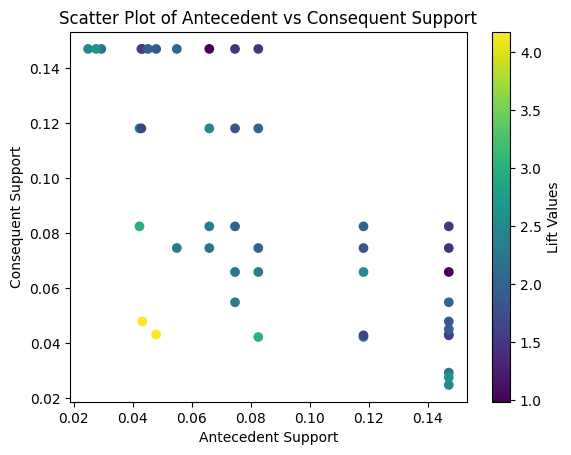

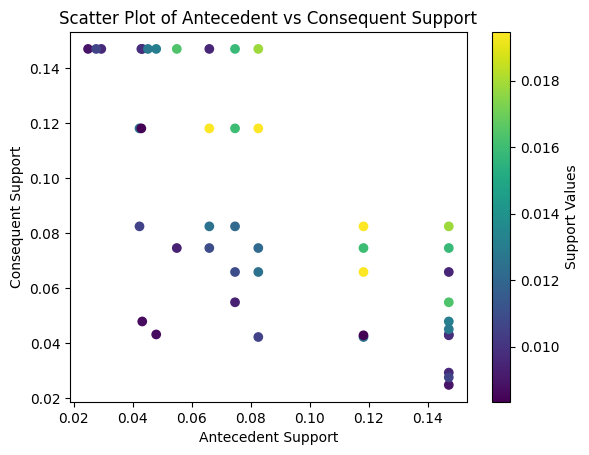

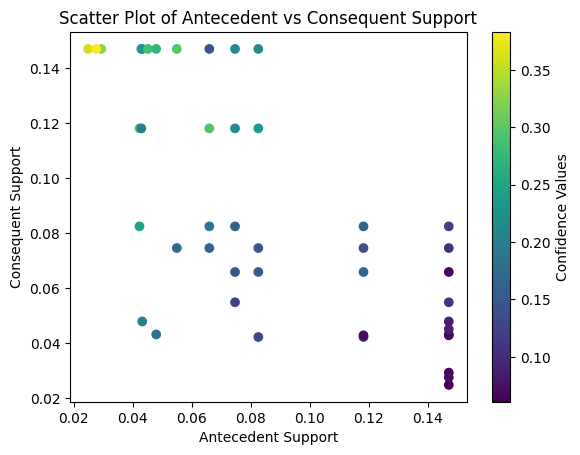

In [46]:
import matplotlib.pyplot as plt
colormap=plt.cm.viridis

# Extracting antecedent and consequent support
antecedent_supports = association["antecedent support"]
consequent_supports = association["consequent support"]
lift = association["lift"]
support = association["support"]
confidence = association["confidence"]

# hover_text = []
# for result in association:
#     hover_text.append()

# Plotting scatter graph (Lift)
plt.scatter(antecedent_supports, consequent_supports, c=lift, cmap=colormap)
plt.xlabel('Antecedent Support')
plt.ylabel('Consequent Support') 
plt.title('Scatter Plot of Antecedent vs Consequent Support')
plt.colorbar(label='Lift Values')
plt.show()

# Plotting scatter graph (Support)
plt.scatter(antecedent_supports, consequent_supports, c=support, cmap=colormap)
plt.xlabel('Antecedent Support')
plt.ylabel('Consequent Support') 
plt.title('Scatter Plot of Antecedent vs Consequent Support')
plt.colorbar(label='Support Values')
plt.show()

# Plotting scatter graph (Confidence)
plt.scatter(antecedent_supports, consequent_supports, c=confidence, cmap=colormap)
plt.xlabel('Antecedent Support')
plt.ylabel('Consequent Support') 
plt.title('Scatter Plot of Antecedent vs Consequent Support')
plt.colorbar(label='Confidence Values')
plt.show()

### Delete datasets and close Spark Session

In [ ]:
del(order_products)
del(grouped_orders)

# Customer Loyalty Analysis

Another dimension of applying Apriori is by grouping items based on product_ids and selecting the orders which have the specified support value. Grouping orders by product IDs to identify patterns of co-purchased products within transactions, aids in the identification of loyal customers characterized by high support values. We then identify top 3 customers and reward them. This approach facilitates targeted marketing strategies, personalized recommendations, and customer retention efforts tailored to the preferences and behaviors of loyal customers within the analyzed department's sales data.

In [3]:
order_products_merged = spark.read.csv("apriori_subset.csv", header=True, inferSchema=True)

In [4]:
# group orders_id based on product_id
grouped_orders = order_products_merged.groupBy("product_id") \
    .agg(collect_list("order_id").alias("order_ids"))

# Convert DataFrame to Python list of lists
dataset = grouped_orders.select("product_id","order_ids").rdd.map(lambda row: row.order_ids).collect()

In [5]:
# transaction encoding for list of lists
te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)

In [6]:
# apply apriori to get frequent order_id with appropriate support
frequent_itemsets = apriori(df, min_support=0.0015, use_colnames=True)
print(frequent_itemsets.sort_values(by='support', ascending=False))

     support            itemsets
0   0.002886             (61355)
22  0.002454           (2136777)
33  0.002227           (3279252)
28  0.002091           (2467301)
35  0.002068  (3279252, 2467301)
26  0.001977           (2328413)
14  0.001977           (1526911)
23  0.001909           (2196187)
8   0.001863            (862978)
21  0.001818           (2118581)
16  0.001818           (1719798)
19  0.001795           (2100750)
27  0.001750           (2399749)
29  0.001727           (2621428)
17  0.001727           (1818780)
20  0.001727           (2106302)
10  0.001682            (903110)
9   0.001682            (871281)
1   0.001659            (267132)
11  0.001636           (1242472)
6   0.001636            (596253)
2   0.001636            (288915)
13  0.001613           (1348096)
32  0.001613           (3046916)
24  0.001613           (2256933)
30  0.001613           (2640800)
5   0.001591            (492766)
15  0.001591           (1648217)
25  0.001568           (2279318)
31  0.0015

In [11]:
frequent_csv_name_orders = f"apriori_frequent_order.csv"
frequent_itemsets.to_csv(frequent_csv_name_orders, index=False)

In [7]:
temp = frequent_itemsets.sort_values(by='support', ascending=False)


# Convert the column to a set without sorting
# Extract integers from frozensets and create a set

from itertools import chain

order_list = list(chain(*temp["itemsets"]))
order_list = list(dict.fromkeys(order_list))
print(order_list)

orders = pd.read_csv("orders.csv")

# Filter orders dataset based on order_list
filtered_orders = orders[orders['order_id'].isin(order_list)]

# Create a new DataFrame with columns order_list and user_id
new_df = pd.DataFrame({'order_list': filtered_orders['order_id'], 'user_id': filtered_orders['user_id']})


print(new_df)

print(new_df["user_id"].value_counts())

[61355, 2136777, 3279252, 2467301, 2328413, 1526911, 2196187, 862978, 2118581, 1719798, 2100750, 2399749, 2621428, 1818780, 2106302, 903110, 871281, 267132, 1242472, 596253, 288915, 1348096, 3046916, 2256933, 2640800, 492766, 1648217, 2279318, 2916367, 3383594, 1340653, 407858, 469471, 854647, 1861711]
         order_list  user_id
37676       1861711     2335
380637        61355    22906
865220      2100750    52008
957705      3046916    57480
980267      2118581    58933
986682       288915    59321
1009960     2136777    60694
1090182     2256933    65678
1115357      903110    67094
1213989     2621428    73000
1586355      596253    95241
1685097      469471   101141
1706814     1719798   102470
1886559     3383594   113238
2016567     2640800   121166
2099908     2916367   126266
2125631     2196187   127856
2150969     1818780   129387
2159886     2279318   129928
2159888     2328413   129928
2159892     1648217   129928
2284944     2399749   137628
2310184      407858   139117


In [12]:
spark.stop()

We see that the top orders are - 61355, 2136777, 3279252.
We query the users table to get the users corresponding to these order ids.
Below are the possible rewards we assign to them:
1. Loyalty points redeemable for free products
2. Exclusive discounts for future purchazes